


# **Import libraries**


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from abc import ABC, abstractmethod



# **Data Loading and Preparation**

In [2]:
# Load data
(x_train_full, y_train_full), (x_test, y_test) = keras.datasets.mnist.load_data()

# Normalize images
x_train_full = x_train_full.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# Create validation set
x_train, x_valid = x_train_full[:50000], x_train_full[50000:]
y_train, y_valid = y_train_full[:50000], y_train_full[50000:]

# Prepare data for different models
# For RF and NN: flatten images into vectors
x_train_flat = x_train.reshape(-1, 28 * 28)
x_test_flat = x_test.reshape(-1, 28 * 28)

# For CNN: add color channel
x_train_cnn = np.expand_dims(x_train, -1)
x_test_cnn = np.expand_dims(x_test, -1)

print(f"Data shape for RF/NN (training): {x_train_flat.shape}")
print(f"Data shape for CNN (training): {x_train_cnn.shape}")
print(f"Label shape (training): {y_train.shape}")


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Data shape for RF/NN (training): (50000, 784)
Data shape for CNN (training): (50000, 28, 28, 1)
Label shape (training): (50000,)


# **Implementing the OOP framework**

In [3]:
class MnistClassifierInterface(ABC):
    """
    Abstract base class (interface) for MNIST classifiers.
    Defines the required methods that must be implemented in all child classes.
    """
    @abstractmethod
    def train(self, X_train, y_train):
        """Trains the model on the provided data."""
        pass

    @abstractmethod
    def predict(self, X_test):
        """Makes predictions on new data."""
        pass


In [4]:
class RandomForestClassifierImpl(MnistClassifierInterface):
    """Implementation of a classifier based on Random Forest."""
    def __init__(self, n_estimators=100, random_state=42):
        self.model = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state, n_jobs=-1)
        self._is_trained = False

    def train(self, X_train, y_train):
        print("Training Random Forest model...")
        self.model.fit(X_train, y_train)
        self._is_trained = True
        print("Training completed.")

    def predict(self, X_test):
        if not self._is_trained:
            raise RuntimeError("The model is not trained yet. Call train() before predict().")
        return self.model.predict(X_test)


In [5]:
class FeedForwardNNClassifierImpl(MnistClassifierInterface):
    """Implementation of a classifier based on a fully connected neural network."""
    def __init__(self):
        self.model = keras.Sequential([
            layers.Flatten(input_shape=(28, 28)),
            layers.Dense(128, activation="relu"),
            layers.Dense(64, activation="relu"),
            layers.Dense(10, activation="softmax")
        ])
        self.model.compile(optimizer="adam",
                           loss="sparse_categorical_crossentropy",
                           metrics=["accuracy"])
        self._is_trained = False

    def train(self, X_train, y_train):
        print("Training Feed-Forward NN model...")
        self.model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.1, verbose=0)
        self._is_trained = True
        print("Training completed.")

    def predict(self, X_test):
        if not self._is_trained:
            raise RuntimeError("The model is not trained yet. Call train() before predict().")
        probabilities = self.model.predict(X_test)
        return np.argmax(probabilities, axis=1)


In [6]:
class CNNClassifierImpl(MnistClassifierInterface):
    """Implementation of a classifier based on a Convolutional Neural Network (CNN)."""
    def __init__(self):
        self.model = keras.Sequential([
            layers.Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1)),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dropout(0.5),
            layers.Dense(10, activation="softmax")
        ])
        self.model.compile(optimizer="adam",
                           loss="sparse_categorical_crossentropy",
                           metrics=["accuracy"])
        self._is_trained = False

    def train(self, X_train, y_train):
        print("Training CNN model...")
        # For CNN, data must be in the format (n, 28, 28, 1)
        X_train_cnn = np.expand_dims(X_train, -1)
        self.model.fit(X_train_cnn, y_train, epochs=5, batch_size=128, validation_split=0.1, verbose=0)
        self._is_trained = True
        print("Training completed.")

    def predict(self, X_test):
        if not self._is_trained:
            raise RuntimeError("The model is not trained yet. Call train() before predict().")
        # For CNN, data must be in the format (n, 28, 28, 1)
        X_test_cnn = np.expand_dims(X_test, -1)
        probabilities = self.model.predict(X_test_cnn)
        return np.argmax(probabilities, axis=1)


In [7]:
class MnistClassifier:
    """
    Main facade class that provides a unified interface
    for working with different MNIST classification models.
    """
    def __init__(self, algorithm: str):
        """
        Initializes the classifier based on the selected algorithm.
        :param algorithm: 'rf' (Random Forest), 'nn' (Feed-Forward Neural Network), or 'cnn' (Convolutional NN).
        """
        self.algorithm_name = algorithm
        if algorithm == 'rf':
            # For RF, data must be flattened
            self._data_adapter = lambda x: x.reshape(-1, 28 * 28)
            self._model_impl = RandomForestClassifierImpl()
        elif algorithm == 'nn':
            # For NN, no reshaping needed, Keras Flatten handles it
            self._data_adapter = lambda x: x
            self._model_impl = FeedForwardNNClassifierImpl()
        elif algorithm == 'cnn':
            # For CNN, data should be 4D, but we handle this inside the CNN class
            self._data_adapter = lambda x: x
            self._model_impl = CNNClassifierImpl()
        else:
            raise ValueError(f"Unknown algorithm: {algorithm}. Available options: 'rf', 'nn', 'cnn'.")

    def train(self, X_train, y_train):
        """Trains the selected model."""
        print(f"--- Starting training for algorithm: {self.algorithm_name} ---")
        adapted_X_train = self._data_adapter(X_train)
        self._model_impl.train(adapted_X_train, y_train)

    def predict(self, X_test):
        """Makes predictions using the trained model."""
        print(f"--- Making predictions for algorithm: {self.algorithm_name} ---")
        adapted_X_test = self._data_adapter(X_test)
        return self._model_impl.predict(adapted_X_test)

    def evaluate(self, X_test, y_test):
        """Evaluates the model and prints metrics."""
        predictions = self.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        report = classification_report(y_test, predictions)

        print("\n--- Evaluation Results ---")
        print(f"Accuracy: {accuracy:.4f}")
        print("\nClassification Report:")
        print(report)
        return accuracy, report


# **Working demonstration**

In [8]:
# Create an instance of the classifier for Random Forest
rf_classifier = MnistClassifier(algorithm='rf')

# Train the model (using original data; the adapter will handle preprocessing)
rf_classifier.train(x_train, y_train)

# Evaluate the model
rf_accuracy, rf_report = rf_classifier.evaluate(x_test, y_test)


--- Starting training for algorithm: rf ---
Training Random Forest model...
Training completed.
--- Making predictions for algorithm: rf ---

--- Evaluation Results ---
Accuracy: 0.9680

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.97      0.96      1032
           3       0.96      0.96      0.96      1010
           4       0.97      0.97      0.97       982
           5       0.97      0.97      0.97       892
           6       0.97      0.98      0.98       958
           7       0.97      0.96      0.96      1028
           8       0.96      0.95      0.96       974
           9       0.95      0.95      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [9]:
# Create an instance of the classifier for Feed-Forward NN
nn_classifier = MnistClassifier(algorithm='nn')

# Train the model
nn_classifier.train(x_train, y_train)

# Evaluate the model
nn_accuracy, nn_report = nn_classifier.evaluate(x_test, y_test)


--- Starting training for algorithm: nn ---
Training Feed-Forward NN model...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training completed.
--- Making predictions for algorithm: nn ---
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

--- Evaluation Results ---
Accuracy: 0.9746

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.97      0.98      0.98      1032
           3       0.94      0.98      0.96      1010
           4       0.98      0.97      0.98       982
           5       0.99      0.94      0.96       892
           6       0.99      0.97      0.98       958
           7       0.98      0.96      0.97      1028
           8       0.98      0.96      0.97       974
           9       0.96      0.97      0.97      1009

    accuracy                           0.97     10000
   macro avg       0.98      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [10]:
# Create an instance of the classifier for CNN
cnn_classifier = MnistClassifier(algorithm='cnn')

# Train the model
cnn_classifier.train(x_train, y_train)

# Evaluate the model
cnn_accuracy, cnn_report = cnn_classifier.evaluate(x_test, y_test)


--- Starting training for algorithm: cnn ---
Training CNN model...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training completed.
--- Making predictions for algorithm: cnn ---
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

--- Evaluation Results ---
Accuracy: 0.9848

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.99      0.98      1032
           3       0.99      0.98      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.97      0.99      0.98       892
           6       0.99      0.99      0.99       958
           7       0.98      0.98      0.98      1028
           8       1.00      0.95      0.97       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000




--- Example predictions from the CNN model ---
--- Making predictions for algorithm: cnn ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


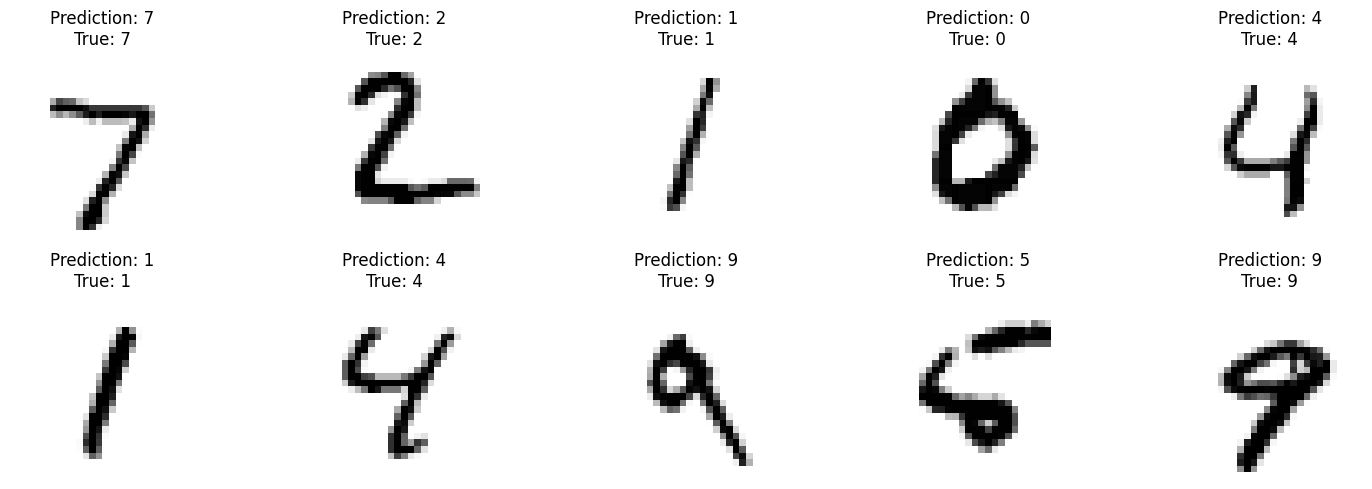

In [11]:
def plot_predictions(classifier, X_data, y_true, num_images=10):
    predictions = classifier.predict(X_data)

    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(2, 5, i + 1)
        plt.imshow(X_data[i], cmap='binary')
        plt.title(f"Prediction: {predictions[i]}\nTrue: {y_true[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

print("\n--- Example predictions from the CNN model ---")
plot_predictions(cnn_classifier, x_test[:10], y_test[:10])
